In [3]:
import torch
import random
import gc
import dataclasses
import tqdm
import os

import numpy as np
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, AutoModelForCausalLM

def load_model_and_tokenizer(gpu_num, model_name="meta-llama/Meta-Llama-3-8B-Instruct"):
    device = torch.device(f"cuda:{gpu_num}")
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
    ).to(device).to(torch.bfloat16)
    tokenizer = AutoTokenizer.from_pretrained(
        model_name,
    )
    tokenizer.pad_token_id = tokenizer.eos_token_id
    model.eval()
    return model, tokenizer


def clear_hooks(input_hooks):
    for hook in input_hooks:
        hook.remove()
    input_hooks = []
    gc.collect()

In [2]:
try:
    from huggingface_hub import login
except:
    !pip install huggingface_hub
    from huggingface_hub import login
# either argue your huggingface token, or put it in a file
# named "your_token.txt" in the working directory
with open("your_token.txt", "r") as f:
    your_token = f.read().strip()
login(token=your_token)

# Load model and tokenizer

In [3]:
# Choose model here
# Options are keys of model_names dict below
model_alias = "llama-3-instruct"

In [4]:
model_names = {
    "pythia-7b": "EleutherAI/pythia-6.9b",
    "llama-3-1": "meta-llama/Llama-3.1-8B",
    "llama-3-instruct":"meta-llama/Meta-Llama-3-8B-Instruct",
    "llama-2-7b-chat": "meta-llama/Llama-2-7b-chat-hf",
}
space_token = {
    "pythia-7b": "Ġ",
    "llama-3-1": "Ġ",
    "llama-2-7b-chat": "▁",
    "llama-3-instruct":" ",
}[model_alias]
model_name = model_names[model_alias]
model, tokenizer = load_model_and_tokenizer(0, model_name=model_name)
device = model.device

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

# Load data

In [5]:
countries_df = pd.read_csv("data/countries.csv")
names_df = pd.read_csv("data/names.csv", index_col=0)

countries_to_capitals = countries_df.set_index("country")["capital"].to_dict()
names = names_df["name"].tolist()

# Keep only single token countries and names
countries_to_capitals = {k: v for k, v in countries_to_capitals.items() if len(tokenizer.encode(f" {k}", add_special_tokens=False)) == 1}
names = [n for n in names if len(tokenizer.encode(n, add_special_tokens=False)) == 1]

print(f"Number of countries: {len(countries_to_capitals)}, Sample: {list(countries_to_capitals.items())[:5]}")
print(f"Number of names: {len(names)}, Sample: {names[:5]}")

Number of countries: 125, Sample: [('Afghanistan', 'Kabul'), ('Albania', 'Tirana'), ('Algeria', 'Algiers'), ('Angola', 'Luanda'), ('Argentina', 'Buenos Aires')]
Number of names: 59, Sample: ['Michael', 'James', 'John', 'Robert', 'David']


# Prompt generation

In [6]:
@dataclasses.dataclass(frozen=True)
class Prompt:
    context: str
    questions: list[str]
    answers: list[str]
    names: list[str]
    countries: list[str]


def generate_prompt_pair(
    num_entities,
    all_names=names,
    all_countries=list(countries_to_capitals.keys()),
    parot=False,
):
    """
    Args:
        parot: bool
            if true, will simplify the problem such that the answer
            merely requires regurgitating the already specified city.
            Otherwise, model needs to associate the countries with
            their capitals.
    """
    cs = random.sample(all_countries, num_entities*2)
    ns = random.sample(all_names, num_entities*2)

    cs_1 = cs[:num_entities]
    ns_1 = ns[:num_entities]
    cs_2 = cs[num_entities:]
    ns_2 = ns[num_entities:]

    if parot:
        target_answers = [c for c in cs_1]
        source_answers = [c for c in cs_2]
        es_1 = [f"{n} lives in {c}." for c, n in zip(target_answers, ns_1)]
        es_2 = [f"{n} lives in {c}." for c, n in zip(source_answers, ns_2)]
        target_questions = [f"Question: What country does {n} live in?" for n in ns_1]
        source_questions = [f"Question: What country does {n} live in?" for n in ns_2]
    else:
        es_1 = [f"{n} lives in the capital city of {c}." for c, n in zip(cs_1, ns_1)]
        es_2 = [f"{n} lives in the capital city of {c}." for c, n in zip(cs_2, ns_2)]
        target_answers = [countries_to_capitals[c] for c in cs_1]
        source_answers = [countries_to_capitals[c] for c in cs_2]
        target_questions = [f"Question: Which city does {n} live in?" for n in ns_1]
        source_questions = [f"Question: Which city does {n} live in?" for n in ns_2]
    target_context =  f"Answer the question based on the context below. Keep the answer short.\n\nContext: {' '.join(es_1)}"
    source_context =  f"Answer the question based on the context below. Keep the answer short.\n\nContext: {' '.join(es_2)}"
    return (Prompt(
        context=target_context,
        questions=target_questions,
        answers=target_answers,
        names=ns_1,
        countries=cs_1,
    ), Prompt(
        context=source_context,
        questions=source_questions,
        answers=source_answers,
        names=ns_2,
        countries=cs_2,
    ))


In [7]:
parot = False # if true, task will be to predicted the provided attributes. if false, predict cities from attributes
target_prompt, source_prompt = generate_prompt_pair(2, parot=parot)
print("Target:", target_prompt.context)
print("Questions:", target_prompt.questions)
print("Answers:", target_prompt.answers)
print()
print("Source:", source_prompt.context)
print("Questions:", source_prompt.questions)
print("Answers", source_prompt.answers)

Target: Answer the question based on the context below. Keep the answer short.

Context: Larry lives in the capital city of Colombia. Christopher lives in the capital city of Cyprus.
Questions: ['Question: Which city does Larry live in?', 'Question: Which city does Christopher live in?']
Answers: ['Bogotá', 'Nicosia']

Source: Answer the question based on the context below. Keep the answer short.

Context: Jordan lives in the capital city of Libya. Eric lives in the capital city of Japan.
Questions: ['Question: Which city does Jordan live in?', 'Question: Which city does Eric live in?']
Answers ['Tripoli', 'Tokyo']


# Patching experiment

In [8]:
def save_outputs(layer: int, save_map: dict):
    """Hook function for saving the output of a model component"""
    def hook_fn(module, input, output):
        if isinstance(output, tuple):
            proj_output = output[0]
        else:
            proj_output = output
        save_map[layer] = proj_output.clone()
        return output
    return hook_fn


def save_hidden_states(ids, model):
    """Save the hidden states of a model. Returns model output and a (num_layers,num_tokens,hidden_size) tensor of hidden states."""
    hooks = []
    hidden_states = {}
    model_layers = model.gpt_neox.layers if "pythia" in model_name else model.model.layers
    for layer,model_layer in enumerate(model_layers):
        hidden_state_hook_handle = model_layer.register_forward_hook(
            save_outputs(layer, hidden_states)
        )
        hooks.append(hidden_state_hook_handle)
    with torch.no_grad():
        out = model(
            ids,
            attention_mask=torch.ones_like(ids),
        )
    clear_hooks(hooks)
    hidden_states_tensor = torch.stack([hidden_states[i] for i in range(len(hidden_states))], dim=0).squeeze(1)
    return out, hidden_states_tensor


def replace_outputs(layer: int, target_layers: list[int], target_position: int, original_hidden_states: dict, modified_hidden_states: dict):
    """Hook function for replacing hidden states of a target layer at a target position with the hidden states from a modified prompt."""
    def hook_fn(module, input, output):
        if isinstance(output, tuple):
            proj_output = output[0]
        else:
            proj_output = output

        unsqueeze = len(proj_output.shape)>2
        proj_output = proj_output.squeeze()
        #proj_output = original_hidden_states[layer].clone()
        if layer in target_layers:
            proj_output[target_position:target_position+2,:] = modified_hidden_states[layer,target_position:target_position+2,:].clone()
        if unsqueeze: proj_output = proj_output[None]

        if isinstance(output, tuple):
            return (proj_output,) + output[1:]
        else:
            return proj_output
    return hook_fn


def replace_hidden_states(ids, model, target_position, original_hidden_states, modified_hidden_states):
    """Replace the hidden states of a model. Returns model output."""
    hooks = []
    model_layers = model.gpt_neox.layers if "pythia" in model_name else model.model.layers
    for layer,model_layer in enumerate(model_layers):
        hidden_state_hook_handle = model_layer.register_forward_hook(
            replace_outputs(
                layer,
                list(range(len(model_layers))),
                target_position,
                original_hidden_states,
                modified_hidden_states
            )
        )
        hooks.append(hidden_state_hook_handle)
    with torch.no_grad():
        try:
            out = model(
                ids,
                attention_mask=torch.ones_like(ids),
            )
        except:
            clear_hooks(hooks)
            assert False
    clear_hooks(hooks)
    return out

In [9]:
def manual_decode(token_ids, tokenizer):
    decoded = []
    for tok in token_ids:
        decoded.append(tokenizer.decode(tok))
    return decoded
        
def batch_manual_decode(token_ids, tokenizer):
    all_decoded = []
    for samp in range(len(token_ids)):
        decoded = manual_decode(token_ids[samp], tokenizer)
        all_decoded.append(decoded)
    return all_decoded

In [10]:
debug = False
rows = []
nruns = 100 if not debug else 5
for run in tqdm.tqdm(range(nruns)):
    
    mp, ap = generate_prompt_pair(2)
    for query_entity_idx in range(4):
        
        query_entities = mp.names + ap.names
        questions = mp.questions + ap.questions
        if parot:
            main_prompt = mp.context + "\n" + questions[query_entity_idx] + f"\nAnswer: {query_entities[query_entity_idx]} lives in"
            alt_prompt = ap.context + "\n" + questions[query_entity_idx] + f"\nAnswer: {query_entities[query_entity_idx]} lives in"
        else:
            main_prompt = mp.context + "\n" + questions[query_entity_idx] + f"\nAnswer: {query_entities[query_entity_idx]} lives in the city of"
            alt_prompt = ap.context + "\n" + questions[query_entity_idx] + f"\nAnswer: {query_entities[query_entity_idx]} lives in the city of"

        main_prompt_tokens = tokenizer(main_prompt, return_tensors="pt").to(device)
        alt_prompt_tokens = tokenizer(alt_prompt, return_tensors="pt").to(device)
        main_ids = main_prompt_tokens["input_ids"]
        alt_ids = alt_prompt_tokens["input_ids"]

        #main_decoded_tokens = tokenizer.convert_ids_to_tokens(main_prompt_tokens["input_ids"][0])
        main_decoded_tokens = manual_decode(main_prompt_tokens["input_ids"][0], tokenizer)
        main_n1_index = main_decoded_tokens.index(f"{space_token}{mp.names[0]}")
        main_n2_index = main_decoded_tokens.index(f"{space_token}{mp.names[1]}")
        main_c1_index = main_decoded_tokens.index(f"{space_token}{mp.countries[0]}")
        main_c2_index = main_decoded_tokens.index(f"{space_token}{mp.countries[1]}")
        
        #alt_decoded_tokens = tokenizer.convert_ids_to_tokens(alt_prompt_tokens["input_ids"][0])
        alt_decoded_tokens = manual_decode(alt_prompt_tokens["input_ids"][0], tokenizer)
        alt_n1_index = alt_decoded_tokens.index(f"{space_token}{ap.names[0]}")
        alt_n2_index = alt_decoded_tokens.index(f"{space_token}{ap.names[1]}")
        alt_c1_index = alt_decoded_tokens.index(f"{space_token}{ap.countries[0]}")
        alt_c2_index = alt_decoded_tokens.index(f"{space_token}{ap.countries[1]}")
        if not (main_n1_index == alt_n1_index and main_n2_index == alt_n2_index and main_c1_index == alt_c1_index and main_c2_index == alt_c2_index):
            print("Mismatch in indices")
            continue

        main_a1_id = tokenizer(" " + mp.answers[0], add_special_tokens=False)["input_ids"][0]
        main_a2_id = tokenizer(" " + mp.answers[1], add_special_tokens=False)["input_ids"][0]
        alt_a1_id = tokenizer(" " + ap.answers[0], add_special_tokens=False)["input_ids"][0]
        alt_a2_id = tokenizer(" " + ap.answers[1], add_special_tokens=False)["input_ids"][0]

        # Get hidden states
        with torch.no_grad():
            main_out, main_hidden_states = save_hidden_states(main_ids, model)
            alt_out, alt_hidden_states = save_hidden_states(alt_ids, model)

        for modify_index in [main_n1_index, main_n2_index, main_c1_index, main_c2_index]:

            # Modify hidden states by replacing with alt_hidden_states
            modified_out = replace_hidden_states(main_ids, model, modify_index, main_hidden_states, alt_hidden_states)
            modified_log_probs = F.log_softmax(modified_out.logits[0,-1,:], dim=-1)
            rows += [
                {
                    "run": run,
                    "query_name": ["e0", "e1", "e0'", "e1'"][query_entity_idx],
                    "attribute": ["a0", "a1", "a0'", "a1'"][i],
                    "swap_type": "entity" if modify_index in [main_n1_index, main_n2_index] else "attribute",
                    "swap_index": 0 if modify_index in [main_n1_index, main_c1_index] else 1,
                    "log_prob": modified_log_probs[a_id].item(),
                } for i, a_id in enumerate([main_a1_id, main_a2_id, alt_a1_id, alt_a2_id])
            ]

    df = pd.DataFrame(rows)
    if not os.path.exists(f"results/table-1/{model_alias}"):
        os.makedirs(f"results/table-1/{model_alias}")
    df.to_csv(f"results/table-1/{model_alias}/factorizability.csv", index=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:50<00:00,  2.91s/it]


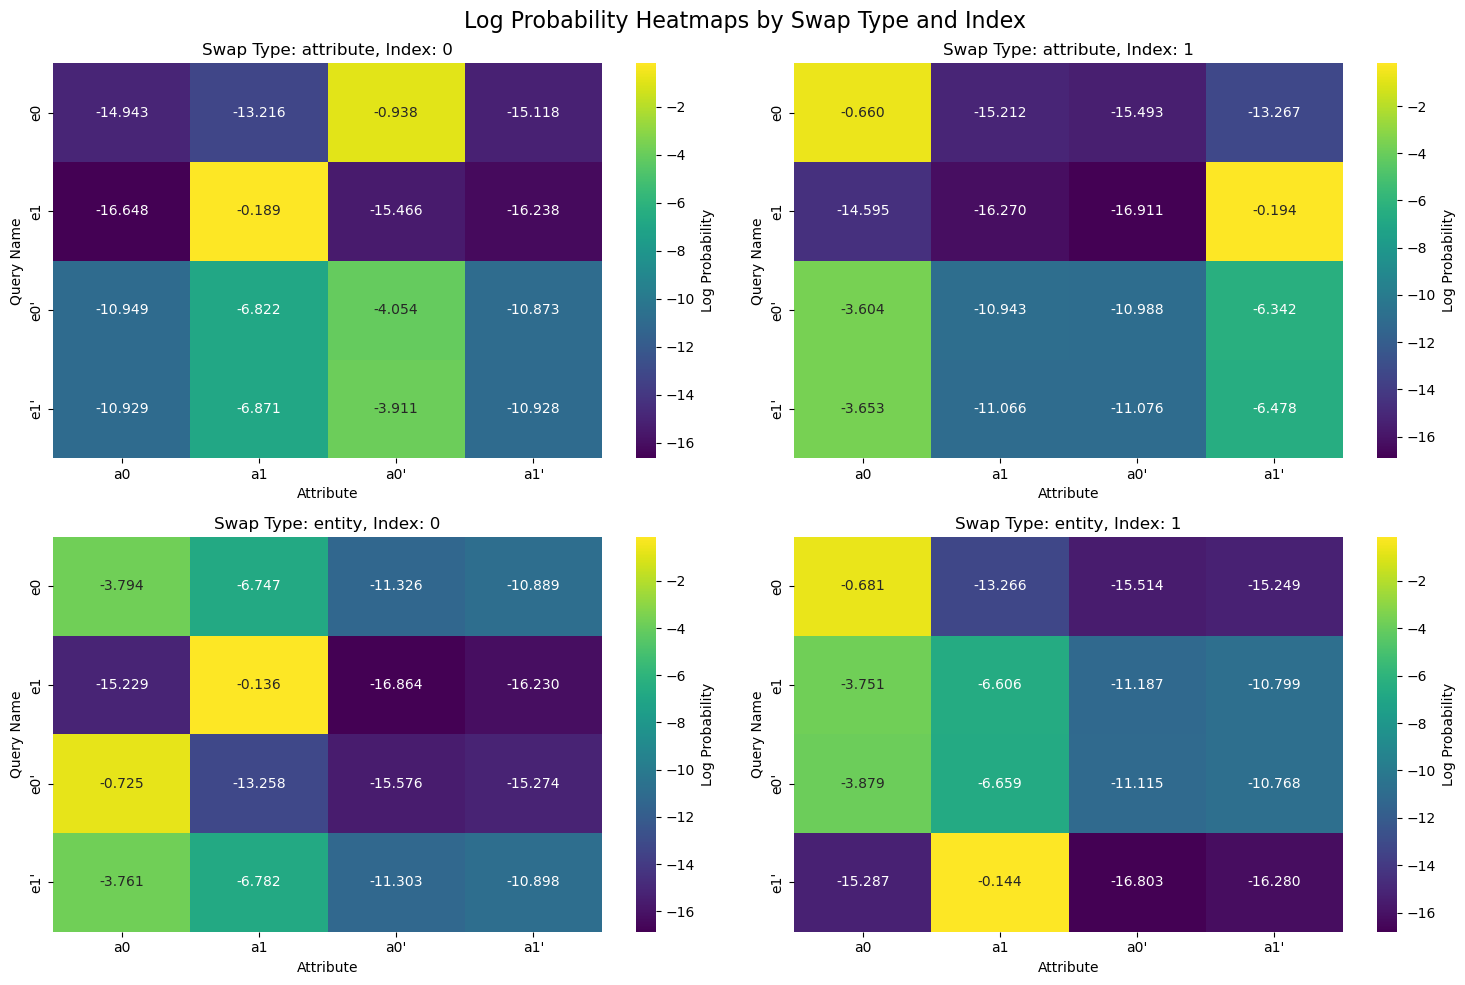

In [11]:
df = pd.read_csv(f"results/table-1/{model_alias}/factorizability.csv")
accuracy_df = df.groupby(["query_name", "attribute", "swap_type", "swap_index"]).mean().reset_index()

# Create subplots for each combination of swap_type and swap_index
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Log Probability Heatmaps by Swap Type and Index', fontsize=16)

# Define the order for consistent plotting
attribute_order = ['a0', 'a1', "a0'", "a1'"]
query_order = ['e0', 'e1', "e0'", "e1'"]

# Get unique combinations of swap_type and swap_index
swap_combinations = accuracy_df[['swap_type', 'swap_index']].drop_duplicates().sort_values(['swap_type', 'swap_index'])

for idx, (_, row) in enumerate(swap_combinations.iterrows()):
    swap_type = row['swap_type']
    swap_index = row['swap_index']
    
    # Filter data for this combination
    subset = accuracy_df[(accuracy_df['swap_type'] == swap_type) & (accuracy_df['swap_index'] == swap_index)]
    
    # Create pivot table for heatmap
    pivot_data = subset.pivot(index='query_name', columns='attribute', values='log_prob')
    
    # Reorder according to specified order
    pivot_data = pivot_data.reindex(index=query_order, columns=attribute_order)
    
    # Determine subplot position
    row_idx = idx // 2
    col_idx = idx % 2
    
    # Create heatmap
    sns.heatmap(pivot_data, 
                annot=True, 
                fmt='.3f', 
                cmap='viridis',
                ax=axes[row_idx, col_idx],
                cbar_kws={'label': 'Log Probability'})
    
    axes[row_idx, col_idx].set_title(f'Swap Type: {swap_type}, Index: {swap_index}')
    axes[row_idx, col_idx].set_xlabel('Attribute')
    axes[row_idx, col_idx].set_ylabel('Query Name')

plt.tight_layout()
plt.show()


#### Additivity replication

In [12]:
def modify_outputs(
    layer: int,
    target_layers: list[int],
    pos1: int,
    pos2: int,
    original_hidden_states: torch.tensor,
    delta: torch.tensor,
    save_hidden_states: dict,
    alt_pos1: int=None,
    alt_pos2: int=None,
    alt_delta: torch.tensor=None,
):
    """Hook function for adding/subtracting a delta to the hidden states of a target layer at a target position."""
    def hook_fn(module, input, output):
        if isinstance(output, tuple):
            proj_output = output[0]
        else:
            proj_output = output

        if layer in target_layers:
            og_output = original_hidden_states[layer].clone()
            unsqueeze = len(proj_output.shape)>2
            proj_output = proj_output.squeeze()
            
            # Intervene
            proj_output[pos1:pos1+2,:] = og_output[pos1:pos1+2,:] + delta[layer,:].clone()
            proj_output[pos2:pos2+2,:] = og_output[pos2:pos2+2,:] - delta[layer,:].clone()
            
            # Intervene again
            if alt_pos1 is not None:
                proj_output[alt_pos1:alt_pos1+2,:] = og_output[alt_pos1:alt_pos1+2,:] + alt_delta[layer,:].clone()
                proj_output[alt_pos2:alt_pos2+2,:] = og_output[alt_pos2:alt_pos2+2,:] - alt_delta[layer,:].clone()
                
            save_hidden_states[layer] = proj_output.clone()
            if unsqueeze: proj_output = proj_output[None]
        
        if isinstance(output, tuple):
            return (proj_output,) + output[1:]
        else:
            return proj_output
    return hook_fn


def modify_hidden_states(
    ids,
    model,
    e0_pos,
    e1_pos,
    a0_pos,
    a1_pos,
    original_hidden_states,
    entity_delta,
    attribute_delta,
    condition,
):
    """Modify the hidden states of a model by adding a delta to the original hidden states. Returns model output."""
    hooks = []
    hidden_states = {}
    model_layers = model.gpt_neox.layers if "pythia" in model_name else model.model.layers
    for layer,model_layer in enumerate(model_layers):
        if "both" in condition:
            hidden_state_hook_handle = model_layer.register_forward_hook(
                modify_outputs(
                    layer=layer,
                    target_layers=list(range(len(model_layers))),
                    pos1=a0_pos,
                    pos2=a1_pos,
                    alt_pos1=e0_pos,
                    alt_pos2=e1_pos,
                    original_hidden_states=original_hidden_states,
                    delta=attribute_delta,
                    alt_delta=entity_delta,
                    save_hidden_states=hidden_states,
                )
            )
            hooks.append(hidden_state_hook_handle)
        elif "attribute" in condition:
            hidden_state_hook_handle = model_layer.register_forward_hook(
                modify_outputs(
                    layer=layer,
                    target_layers=list(range(len(model_layers))),
                    pos1=a0_pos,
                    pos2=a1_pos,
                    original_hidden_states=original_hidden_states,
                    delta=attribute_delta,
                    save_hidden_states=hidden_states,
                )
            )
            hooks.append(hidden_state_hook_handle)
        elif "entity" in condition:
            hidden_state_hook_handle = model_layer.register_forward_hook(
                modify_outputs(
                    layer=layer,
                    target_layers=list(range(len(model_layers))),
                    pos1=e0_pos,
                    pos2=e1_pos,
                    original_hidden_states=original_hidden_states,
                    delta=entity_delta,
                    save_hidden_states=hidden_states,
                )
            )
            hooks.append(hidden_state_hook_handle)
        else:
            raise ValueError(f"Invalid condition: {condition}")
    with torch.no_grad():
        try:
            out = model(
                ids,
                attention_mask=torch.ones_like(ids),
            )
        except:
            clear_hooks(hooks)
            assert False
    hidden_states_tensor = torch.stack([hidden_states[i] for i in range(len(hidden_states))], dim=0).squeeze(1)
    clear_hooks(hooks)
    return out, hidden_states_tensor

In [13]:
# Allocate 'train' and 'test' names and countries for calculating means
train_names = names[:len(names)//2]
test_names = names[len(names)//2:]
train_countries = list(countries_to_capitals.keys())[:len(countries_to_capitals)//2]
test_countries = list(countries_to_capitals.keys())[len(countries_to_capitals)//2:]

# Calculate mean differences
num_runs = 500
attribute_deltas = []
entity_deltas = []

it = tqdm.tqdm(range(5)) if debug else tqdm.tqdm(range(num_runs))
for _ in it:

    mp, ap = generate_prompt_pair(2, train_names, train_countries, parot=parot)

    for query_entity_idx in range(2):

        if parot:
            main_prompt = mp.context + "\n" + mp.questions[query_entity_idx] + f"\nAnswer: {mp.names[query_entity_idx]} lives in"
            alt_prompt = ap.context + "\n" + ap.questions[query_entity_idx] + f"\nAnswer: {ap.names[query_entity_idx]} lives in"
        else:
            main_prompt = mp.context + "\n" + mp.questions[query_entity_idx] + f"\nAnswer: {mp.names[query_entity_idx]} lives in the city of"
            alt_prompt = ap.context + "\n" + ap.questions[query_entity_idx] + f"\nAnswer: {ap.names[query_entity_idx]} lives in the city of"
        
        main_prompt_tokens = tokenizer(main_prompt, return_tensors="pt").to(device)
        alt_prompt_tokens = tokenizer(alt_prompt, return_tensors="pt").to(device)
        main_ids = main_prompt_tokens["input_ids"]
        alt_ids = alt_prompt_tokens["input_ids"]

        main_decoded_tokens = manual_decode(main_prompt_tokens["input_ids"][0], tokenizer)
        alt_decoded_tokens =  manual_decode(alt_prompt_tokens["input_ids"][0], tokenizer)
        main_n1_index = main_decoded_tokens.index(f"{space_token}{mp.names[0]}")
        main_n2_index = main_decoded_tokens.index(f"{space_token}{mp.names[1]}")
        main_c1_index = main_decoded_tokens.index(f"{space_token}{mp.countries[0]}")
        main_c2_index = main_decoded_tokens.index(f"{space_token}{mp.countries[1]}")
        alt_n1_index = alt_decoded_tokens.index(f"{space_token}{ap.names[0]}")
        alt_n2_index = alt_decoded_tokens.index(f"{space_token}{ap.names[1]}")
        alt_c1_index = alt_decoded_tokens.index(f"{space_token}{ap.countries[0]}")
        alt_c2_index = alt_decoded_tokens.index(f"{space_token}{ap.countries[1]}")
        if not (main_n1_index == alt_n1_index and main_n2_index == alt_n2_index and main_c1_index == alt_c1_index and main_c2_index == alt_c2_index):
            print("Mismatch in indices")
            continue

        # Get hidden states
        with torch.no_grad():
            main_out, main_hidden_states = save_hidden_states(main_ids, model)
            alt_out, alt_hidden_states = save_hidden_states(alt_ids, model)

        attribute_deltas.append(main_hidden_states[:, main_c2_index:main_c2_index+2, :] - alt_hidden_states[:, alt_c1_index:alt_c1_index+2, :])
        entity_deltas.append(   main_hidden_states[:, main_n2_index:main_n2_index+2, :] - alt_hidden_states[:, alt_n1_index:alt_n1_index+2, :])

attribute_deltas = torch.stack(attribute_deltas, dim=0).mean(dim=0)
entity_deltas = torch.stack(entity_deltas, dim=0).mean(dim=0)
random_entity_deltas = torch.randn_like(entity_deltas) * entity_deltas.std()
random_attribute_deltas = torch.randn_like(attribute_deltas) * attribute_deltas.std()


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:23<00:00,  1.90it/s]


In [14]:
# Calculate effect of mean interventions
num_runs = 5 if debug else 100
rows = []
all_original_attribute_hidden_states = []
all_original_entity_hidden_states = []
all_intervened_attribute_hidden_states = []
all_intervened_entity_hidden_states = []
all_modified_attribute_hidden_states = []
all_modified_entity_hidden_states = []
for run in tqdm.tqdm(range(num_runs)):

    p, _ = generate_prompt_pair(2, test_names, test_countries, parot=parot)

    for query_entity_idx in range(2):

        if parot:
            prompt = p.context + "\n" + p.questions[query_entity_idx] + f"\nAnswer: {p.names[query_entity_idx]} lives in"
        else:
            prompt = p.context + "\n" + p.questions[query_entity_idx] + f"\nAnswer: {p.names[query_entity_idx]} lives in the city of"

        # Get tokens
        prompt_tokens = tokenizer(prompt, return_tensors="pt").to(device)
        ids = prompt_tokens["input_ids"]
        a1_id = tokenizer(" " + p.answers[0], add_special_tokens=False)["input_ids"][0]
        a2_id = tokenizer(" " + p.answers[1], add_special_tokens=False)["input_ids"][0]

        # Get token positions of entities and attributes
        decoded_tokens = manual_decode(ids[0], tokenizer)
        e0_pos = decoded_tokens.index(f"{space_token}{p.names[0]}")
        e1_pos = decoded_tokens.index(f"{space_token}{p.names[1]}")
        a0_pos = decoded_tokens.index(f"{space_token}{p.countries[0]}")
        a1_pos = decoded_tokens.index(f"{space_token}{p.countries[1]}")

        # control condition
        with torch.no_grad():
            out, original_hidden_states = save_hidden_states(ids, model)
            logprobs = F.log_softmax(out.logits[0, -1], dim=-1)
        rows.append({
            "run_id": run,
            "condition": "control",
            "query_entity_idx": query_entity_idx,
            "max_logprob_token": tokenizer.decode(logprobs.argmax().item()),
            "max_logprob": logprobs.max().item(),
            "a1_token": tokenizer.decode(a1_id),
            "a1_logprob": logprobs[a1_id].item(),
            "a2_token": tokenizer.decode(a2_id),
            "a2_logprob": logprobs[a2_id].item(),
            "correct_answer": "a1" if query_entity_idx == 0 else "a2",
        })
        all_original_attribute_hidden_states.append(original_hidden_states[:, [a0_pos, a0_pos+1, a1_pos, a1_pos+1], :].cpu())
        all_original_entity_hidden_states.append(   original_hidden_states[:, [e0_pos, e0_pos+1, e1_pos, e1_pos+1], :].cpu())

        # Modified conditions
        for condition in ["attribute", "entity", "both", "random-attribute", "random-entity", "random-both"]:
            if "random" in condition:
                out, intervened_hidden_states = modify_hidden_states(
                    ids=ids,
                    model=model,
                    e0_pos=e0_pos,
                    e1_pos=e1_pos,
                    a0_pos=a0_pos,
                    a1_pos=a1_pos,
                    original_hidden_states=original_hidden_states,
                    entity_delta=random_entity_deltas,
                    attribute_delta=random_attribute_deltas,
                    condition=condition,
                )
            else:
                out, intervened_hidden_states = modify_hidden_states(
                    ids=ids,
                    model=model,
                    e0_pos=e0_pos,
                    e1_pos=e1_pos,
                    a0_pos=a0_pos,
                    a1_pos=a1_pos,
                    original_hidden_states=original_hidden_states,
                    entity_delta=entity_deltas,
                    attribute_delta=attribute_deltas,
                    condition=condition,
                )
            logprobs = F.log_softmax(out.logits[0, -1], dim=-1)
            rows.append({
                "run_id": run,
                "condition": condition,
                "query_entity_idx": query_entity_idx,
                "max_logprob_token": tokenizer.decode(logprobs.argmax().item()),
                "max_logprob": logprobs.max().item(),
                "a1_token": tokenizer.decode(a1_id),
                "a1_logprob": logprobs[a1_id].item(),
                "a2_token": tokenizer.decode(a2_id),
                "a2_logprob": logprobs[a2_id].item(),
                "correct_answer": "a1" if query_entity_idx == 0 else "a2",
            })

            if "random" not in condition and "both" not in condition:
                if "attribute" in condition:
                    all_intervened_attribute_hidden_states.append(intervened_hidden_states[:, [a0_pos, a0_pos+1, a1_pos, a1_pos+1], :].cpu())
                else:
                    all_intervened_entity_hidden_states.append(intervened_hidden_states[:, [e0_pos, e0_pos+1, e1_pos, e1_pos+1], :].cpu())

                if "attribute" in condition:
                    attributes = p.countries[::-1]
                    entities = p.names
                else:
                    attributes = p.countries
                    entities = p.names[::-1]
                if parot:
                    modified_prompt = f"Answer the question based on the context below. Keep the answer short.\n\nContext: {entities[0]} lives in {attributes[0]}. {entities[1]} lives in {attributes[1]}.\nQuestion: Where does {p.names[query_entity_idx]} live?\nAnswer: {p.names[query_entity_idx]} lives in"
                else:
                    modified_prompt = f"Answer the question based on the context below. Keep the answer short.\n\nContext: {entities[0]} lives in the capital city of {attributes[0]}. {entities[1]} lives in the capital city of {attributes[1]}.\nQuestion: Which city does {p.names[query_entity_idx]} live in?\nAnswer: {p.names[query_entity_idx]} lives in the city of"
                modified_prompt_tokens = tokenizer(modified_prompt, return_tensors="pt").to(device)
                modified_ids = modified_prompt_tokens["input_ids"]
                with torch.no_grad():
                    _, modified_hidden_states = save_hidden_states(modified_ids, model)
                if "attribute" in condition:
                    all_modified_attribute_hidden_states.append(modified_hidden_states[:, [a0_pos, a0_pos+1, a1_pos, a1_pos+1], :].cpu())
                else:
                    all_modified_entity_hidden_states.append(modified_hidden_states[:, [e0_pos, e0_pos+1, e1_pos, e1_pos+1], :].cpu())

df = pd.DataFrame(rows)
df.to_csv(f"results/table-1/{model_alias}/mean_interventions.csv", index=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:58<00:00,  2.38s/it]


In [15]:
df = pd.read_csv(f"results/table-1/{model_alias}/mean_interventions.csv")

def row_is_correct(row):
    return (row["correct_answer"] == "a1" and row["a1_logprob"] > row["a2_logprob"]) or (row["correct_answer"] == "a2" and row["a2_logprob"] > row["a1_logprob"])

for condition, cdf in df.groupby("condition"):
    accuracy = len([1 for _, row in cdf.iterrows() if row_is_correct(row)]) / len(cdf)
    print(f"{condition}: {accuracy}")

attribute: 0.255
both: 1.0
control: 1.0
entity: 0.705
random-attribute: 0.78
random-both: 0.655
random-entity: 0.87


In [16]:
all_original_attribute_hidden_states_matrix =   torch.stack(all_original_attribute_hidden_states)
all_original_entity_hidden_states_matrix =      torch.stack(all_original_entity_hidden_states)
all_intervened_attribute_hidden_states_matrix = torch.stack(all_intervened_attribute_hidden_states)
all_intervened_entity_hidden_states_matrix =    torch.stack(all_intervened_entity_hidden_states)
all_modified_attribute_hidden_states_matrix =   torch.stack(all_modified_attribute_hidden_states)
all_modified_entity_hidden_states_matrix =      torch.stack(all_modified_entity_hidden_states)

print(all_original_attribute_hidden_states_matrix.shape)
print(all_original_entity_hidden_states_matrix.shape)
print(all_intervened_attribute_hidden_states_matrix.shape)
print(all_intervened_entity_hidden_states_matrix.shape)
print(all_modified_attribute_hidden_states_matrix.shape)
print(all_modified_entity_hidden_states_matrix.shape)

torch.Size([200, 32, 4, 4096])
torch.Size([200, 32, 4, 4096])
torch.Size([200, 32, 4, 4096])
torch.Size([200, 32, 4, 4096])
torch.Size([200, 32, 4, 4096])
torch.Size([200, 32, 4, 4096])


In [18]:
all_intervened_attribute_hidden_states_matrix.shape

torch.Size([200, 32, 4, 4096])

In [19]:
natty_hstates = torch.concat([
    all_modified_attribute_hidden_states_matrix[:200],
    all_modified_entity_hidden_states_matrix[:200],
], dim=0)[::2]
intrv_hstates = torch.concat([
    all_intervened_attribute_hidden_states_matrix[:200],
    all_intervened_entity_hidden_states_matrix[:200],
], dim=0)[::2]


In [20]:
torch.save({"natty": natty_hstates, "intrv": intrv_hstates}, "mean_diff_actvs.p")

In [4]:
temp = torch.load("mean_diff_actvs.p")
natty_hstates = temp["natty"].float()
intrv_hstates = temp["intrv"].float()

In [6]:
def filter_by_layer_and_position(natty_hstates, intrv_hstates, layer=None, pos=None):
    d = natty_hstates.shape[-1]
    if layer is not None:
        natty_hstates = natty_hstates[:,layer]
        intrv_hstates = intrv_hstates[:,layer]
    if pos is None:
        natty_states = [natty_hstates[i].reshape(-1,d) for i in range(len(natty_hstates))]
        intrv_states = [intrv_hstates[i].reshape(-1,d) for i in range(len(natty_hstates))]
    else:
        natty_states = [natty_hstates[i][pos].reshape(-1,d) for i in range(len(natty_hstates))]
        intrv_states = [intrv_hstates[i][pos].reshape(-1,d) for i in range(len(natty_hstates))]
    natty_states = torch.vstack(natty_states)
    intrv_states = torch.vstack(intrv_states)
    return natty_states, intrv_states


Layer: 0 Pos: None
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])


/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:825: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "means": torch.tensor(means),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:826: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "stds": torch.tensor(stds),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expl_vars = torch.tensor(ret["proportion_expl_var"]).float().cpu()
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:177: U

x-dim: 0
y-dim: 1
Top Expl Vars: tensor([0.1438, 0.0746, 0.0496, 0.0250, 0.0218])
Vis Expl Vars: tensor(0.1438) tensor(0.0746)


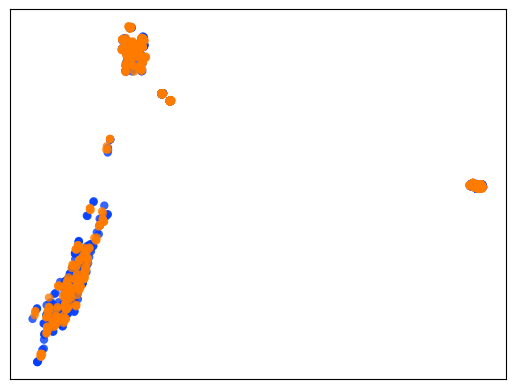

Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Layer: 1 Pos: None
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])


/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:825: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "means": torch.tensor(means),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:826: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "stds": torch.tensor(stds),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expl_vars = torch.tensor(ret["proportion_expl_var"]).float().cpu()
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:177: U

x-dim: 0
y-dim: 1
Top Expl Vars: tensor([0.1841, 0.0766, 0.0622, 0.0223, 0.0213])
Vis Expl Vars: tensor(0.1841) tensor(0.0766)


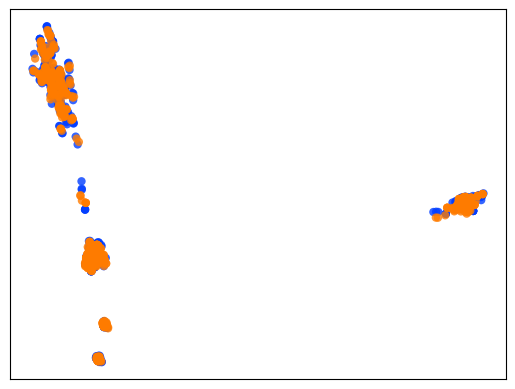

Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Layer: 2 Pos: None
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])


/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:825: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "means": torch.tensor(means),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:826: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "stds": torch.tensor(stds),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expl_vars = torch.tensor(ret["proportion_expl_var"]).float().cpu()
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:177: U

x-dim: 0
y-dim: 1
Top Expl Vars: tensor([0.1745, 0.0691, 0.0610, 0.0367, 0.0254])
Vis Expl Vars: tensor(0.1745) tensor(0.0691)


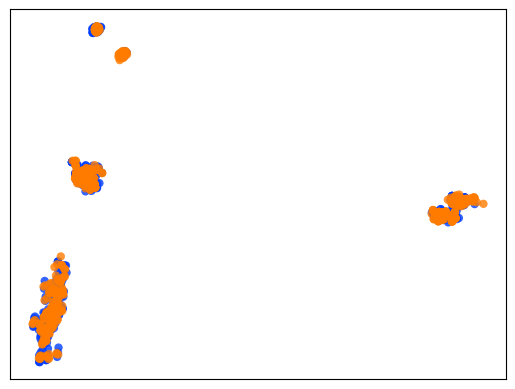

Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Layer: 3 Pos: None
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])


/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:825: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "means": torch.tensor(means),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:826: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "stds": torch.tensor(stds),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expl_vars = torch.tensor(ret["proportion_expl_var"]).float().cpu()
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:177: U

x-dim: 0
y-dim: 1
Top Expl Vars: tensor([0.1782, 0.1042, 0.0626, 0.0578, 0.0381])
Vis Expl Vars: tensor(0.1782) tensor(0.1042)


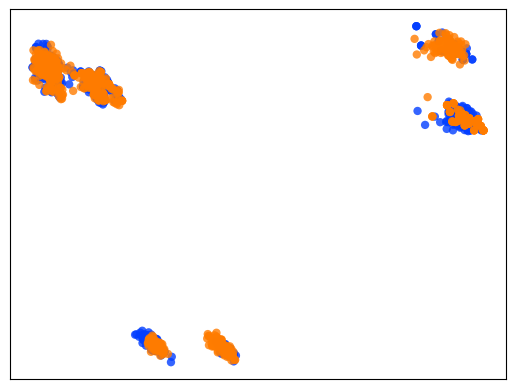

Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Layer: 4 Pos: None
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])


/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:825: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "means": torch.tensor(means),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:826: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "stds": torch.tensor(stds),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expl_vars = torch.tensor(ret["proportion_expl_var"]).float().cpu()
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:177: U

x-dim: 0
y-dim: 1
Top Expl Vars: tensor([0.1719, 0.1268, 0.0771, 0.0711, 0.0470])
Vis Expl Vars: tensor(0.1719) tensor(0.1268)


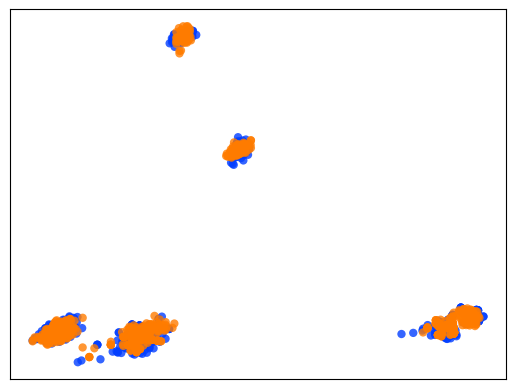

Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Layer: 5 Pos: None
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])


/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:825: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "means": torch.tensor(means),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:826: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "stds": torch.tensor(stds),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expl_vars = torch.tensor(ret["proportion_expl_var"]).float().cpu()
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:177: U

x-dim: 0
y-dim: 1
Top Expl Vars: tensor([0.1822, 0.1320, 0.0947, 0.0845, 0.0581])
Vis Expl Vars: tensor(0.1822) tensor(0.1320)


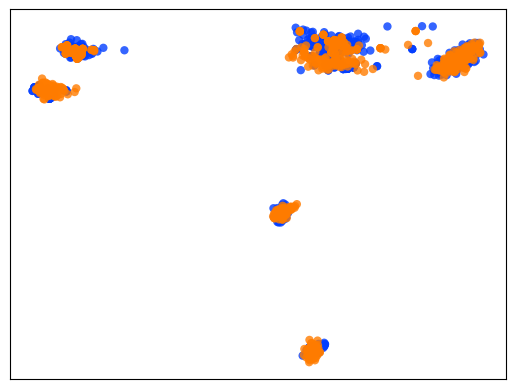

Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Layer: 6 Pos: None
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])


/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:825: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "means": torch.tensor(means),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:826: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "stds": torch.tensor(stds),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expl_vars = torch.tensor(ret["proportion_expl_var"]).float().cpu()
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:177: U

x-dim: 0
y-dim: 1
Top Expl Vars: tensor([0.1955, 0.1248, 0.0994, 0.0953, 0.0535])
Vis Expl Vars: tensor(0.1955) tensor(0.1248)


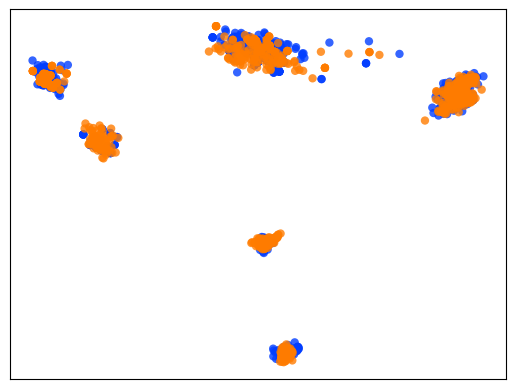

Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Layer: 7 Pos: None
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])


/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:825: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "means": torch.tensor(means),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:826: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "stds": torch.tensor(stds),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expl_vars = torch.tensor(ret["proportion_expl_var"]).float().cpu()
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:177: U

x-dim: 0
y-dim: 1
Top Expl Vars: tensor([0.1876, 0.1272, 0.1078, 0.0899, 0.0608])
Vis Expl Vars: tensor(0.1876) tensor(0.1272)


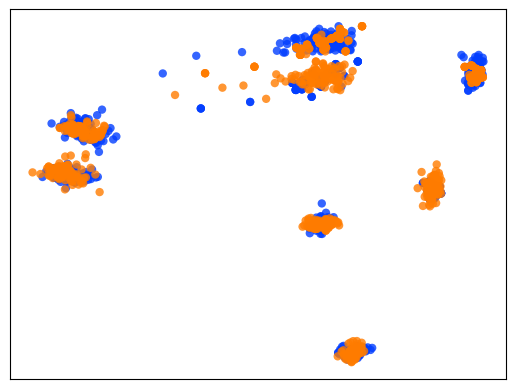

Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Layer: 8 Pos: None
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])


/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:825: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "means": torch.tensor(means),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:826: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "stds": torch.tensor(stds),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expl_vars = torch.tensor(ret["proportion_expl_var"]).float().cpu()
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:177: U

x-dim: 0
y-dim: 1
Top Expl Vars: tensor([0.1829, 0.1334, 0.1283, 0.0857, 0.0620])
Vis Expl Vars: tensor(0.1829) tensor(0.1334)


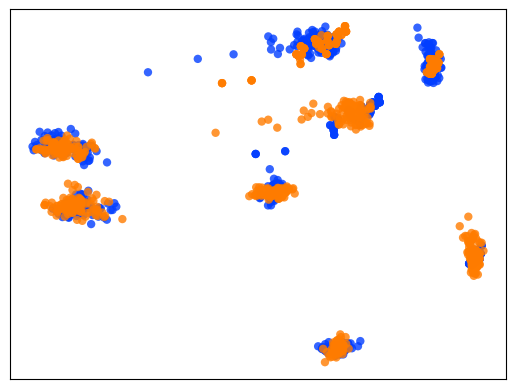

Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Layer: 9 Pos: None
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])


/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:825: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "means": torch.tensor(means),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:826: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "stds": torch.tensor(stds),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expl_vars = torch.tensor(ret["proportion_expl_var"]).float().cpu()
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:177: U

x-dim: 0
y-dim: 1
Top Expl Vars: tensor([0.2040, 0.1330, 0.1224, 0.0867, 0.0683])
Vis Expl Vars: tensor(0.2040) tensor(0.1330)


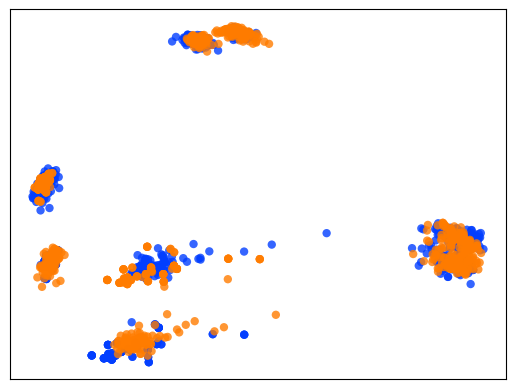

Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Layer: 10 Pos: None
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])


/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:825: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "means": torch.tensor(means),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:826: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "stds": torch.tensor(stds),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expl_vars = torch.tensor(ret["proportion_expl_var"]).float().cpu()
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:177: U

x-dim: 0
y-dim: 1
Top Expl Vars: tensor([0.2080, 0.1393, 0.1277, 0.0890, 0.0693])
Vis Expl Vars: tensor(0.2080) tensor(0.1393)


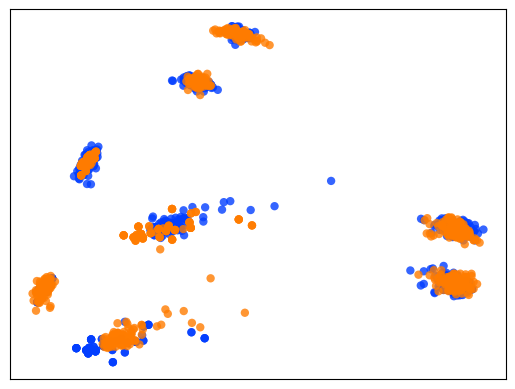

Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Layer: 11 Pos: None
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])


/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:825: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "means": torch.tensor(means),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:826: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "stds": torch.tensor(stds),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expl_vars = torch.tensor(ret["proportion_expl_var"]).float().cpu()
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:177: U

x-dim: 0
y-dim: 1
Top Expl Vars: tensor([0.2059, 0.1455, 0.1288, 0.0930, 0.0689])
Vis Expl Vars: tensor(0.2059) tensor(0.1455)


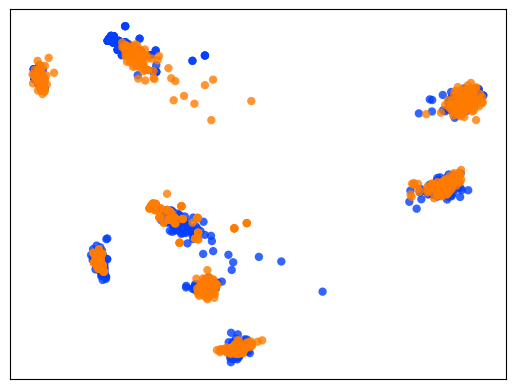

Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Layer: 12 Pos: None
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])


/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:825: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "means": torch.tensor(means),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:826: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "stds": torch.tensor(stds),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expl_vars = torch.tensor(ret["proportion_expl_var"]).float().cpu()
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:177: U

x-dim: 0
y-dim: 1
Top Expl Vars: tensor([0.1987, 0.1484, 0.1265, 0.0938, 0.0748])
Vis Expl Vars: tensor(0.1987) tensor(0.1484)


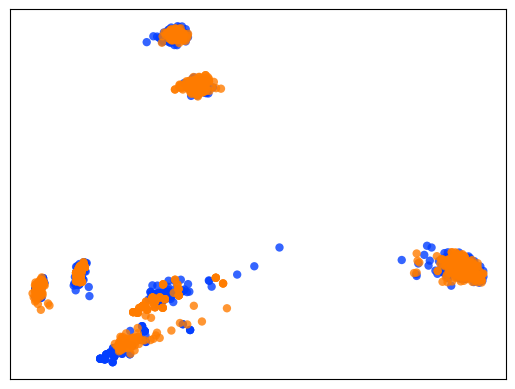

Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Layer: 13 Pos: None
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])


/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:825: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "means": torch.tensor(means),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:826: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "stds": torch.tensor(stds),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expl_vars = torch.tensor(ret["proportion_expl_var"]).float().cpu()
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:177: U

x-dim: 0
y-dim: 1
Top Expl Vars: tensor([0.1961, 0.1526, 0.1169, 0.1062, 0.0797])
Vis Expl Vars: tensor(0.1961) tensor(0.1526)


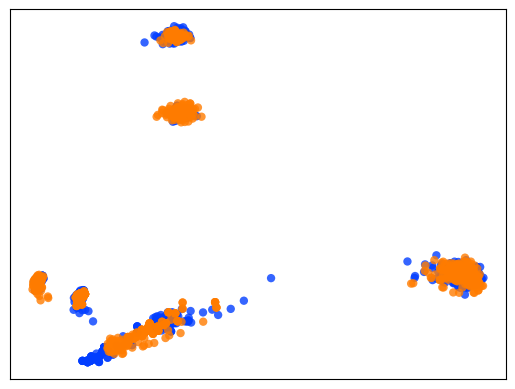

Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Layer: 14 Pos: None
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])


/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:825: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "means": torch.tensor(means),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:826: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "stds": torch.tensor(stds),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expl_vars = torch.tensor(ret["proportion_expl_var"]).float().cpu()
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:177: U

x-dim: 0
y-dim: 1
Top Expl Vars: tensor([0.1927, 0.1523, 0.1099, 0.1005, 0.0789])
Vis Expl Vars: tensor(0.1927) tensor(0.1523)


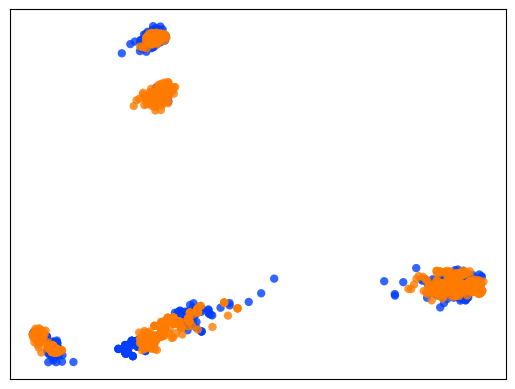

Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Layer: 15 Pos: None
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])


/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:825: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "means": torch.tensor(means),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:826: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "stds": torch.tensor(stds),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expl_vars = torch.tensor(ret["proportion_expl_var"]).float().cpu()
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:177: U

x-dim: 0
y-dim: 1
Top Expl Vars: tensor([0.1778, 0.1473, 0.1185, 0.0931, 0.0762])
Vis Expl Vars: tensor(0.1778) tensor(0.1473)


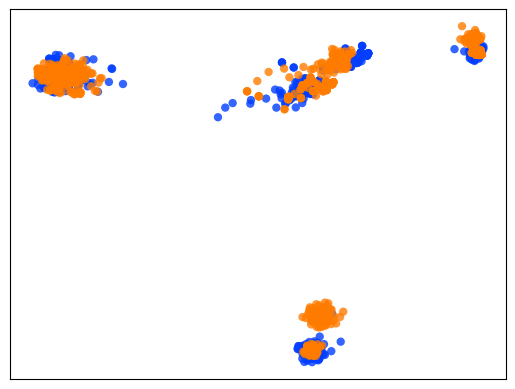

Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Layer: 16 Pos: None
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])


/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:825: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "means": torch.tensor(means),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:826: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "stds": torch.tensor(stds),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expl_vars = torch.tensor(ret["proportion_expl_var"]).float().cpu()
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:177: U

x-dim: 0
y-dim: 1
Top Expl Vars: tensor([0.1747, 0.1432, 0.1029, 0.0812, 0.0697])
Vis Expl Vars: tensor(0.1747) tensor(0.1432)


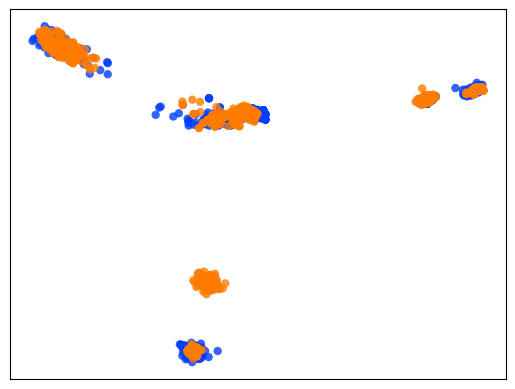

Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Layer: 17 Pos: None
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])


/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:825: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "means": torch.tensor(means),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:826: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "stds": torch.tensor(stds),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expl_vars = torch.tensor(ret["proportion_expl_var"]).float().cpu()
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:177: U

x-dim: 0
y-dim: 1
Top Expl Vars: tensor([0.1609, 0.1406, 0.1005, 0.0753, 0.0629])
Vis Expl Vars: tensor(0.1609) tensor(0.1406)


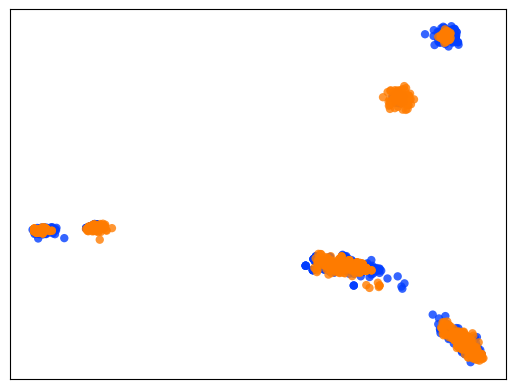

Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Layer: 18 Pos: None
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])


/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:825: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "means": torch.tensor(means),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:826: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "stds": torch.tensor(stds),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expl_vars = torch.tensor(ret["proportion_expl_var"]).float().cpu()
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:177: U

x-dim: 0
y-dim: 1
Top Expl Vars: tensor([0.1576, 0.1421, 0.0952, 0.0814, 0.0577])
Vis Expl Vars: tensor(0.1576) tensor(0.1421)


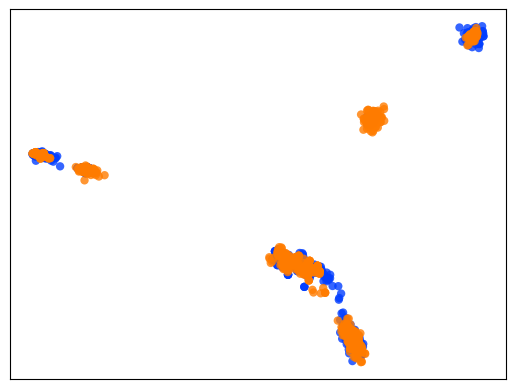

Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Layer: 19 Pos: None
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])


/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:825: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "means": torch.tensor(means),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:826: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "stds": torch.tensor(stds),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expl_vars = torch.tensor(ret["proportion_expl_var"]).float().cpu()
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:177: U

x-dim: 0
y-dim: 1
Top Expl Vars: tensor([0.1620, 0.1350, 0.0903, 0.0769, 0.0518])
Vis Expl Vars: tensor(0.1620) tensor(0.1350)


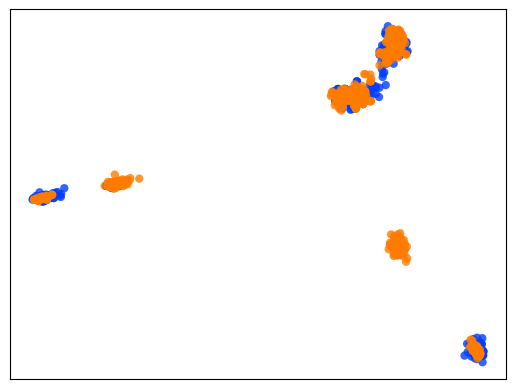

Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Layer: 20 Pos: None
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])


/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:825: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "means": torch.tensor(means),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:826: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "stds": torch.tensor(stds),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expl_vars = torch.tensor(ret["proportion_expl_var"]).float().cpu()
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:177: U

x-dim: 0
y-dim: 1
Top Expl Vars: tensor([0.1687, 0.1253, 0.0840, 0.0730, 0.0509])
Vis Expl Vars: tensor(0.1687) tensor(0.1253)


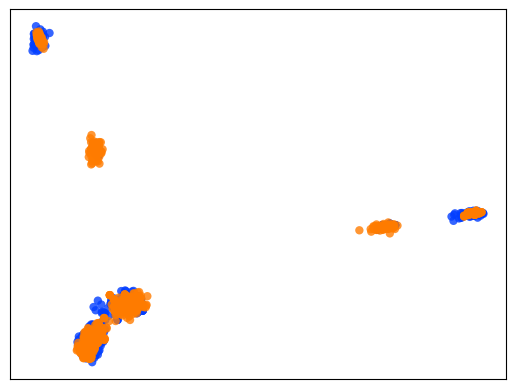

Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Layer: 21 Pos: None
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])


/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:825: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "means": torch.tensor(means),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:826: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "stds": torch.tensor(stds),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expl_vars = torch.tensor(ret["proportion_expl_var"]).float().cpu()
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:177: U

x-dim: 0
y-dim: 1
Top Expl Vars: tensor([0.1730, 0.1165, 0.0800, 0.0708, 0.0492])
Vis Expl Vars: tensor(0.1730) tensor(0.1165)


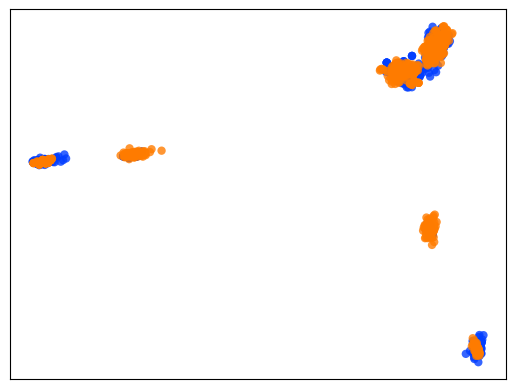

Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Layer: 22 Pos: None
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])


/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:825: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "means": torch.tensor(means),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:826: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "stds": torch.tensor(stds),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expl_vars = torch.tensor(ret["proportion_expl_var"]).float().cpu()
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:177: U

x-dim: 0
y-dim: 1
Top Expl Vars: tensor([0.1746, 0.1179, 0.0787, 0.0712, 0.0483])
Vis Expl Vars: tensor(0.1746) tensor(0.1179)


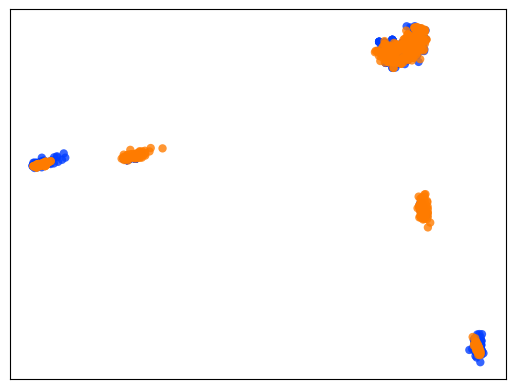

Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Layer: 23 Pos: None
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])


/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:825: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "means": torch.tensor(means),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:826: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "stds": torch.tensor(stds),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expl_vars = torch.tensor(ret["proportion_expl_var"]).float().cpu()
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:177: U

x-dim: 0
y-dim: 1
Top Expl Vars: tensor([0.1752, 0.1142, 0.0806, 0.0708, 0.0473])
Vis Expl Vars: tensor(0.1752) tensor(0.1142)


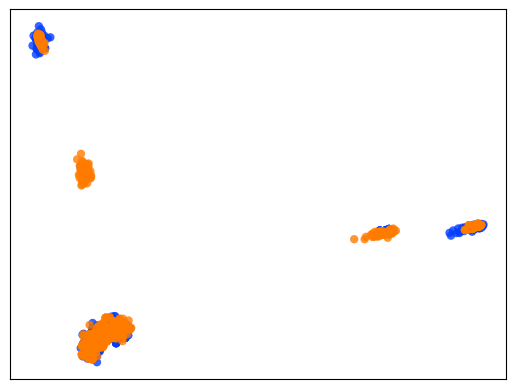

Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Layer: 24 Pos: None
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])


/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:825: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "means": torch.tensor(means),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:826: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "stds": torch.tensor(stds),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expl_vars = torch.tensor(ret["proportion_expl_var"]).float().cpu()
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:177: U

x-dim: 0
y-dim: 1
Top Expl Vars: tensor([0.1700, 0.1106, 0.0832, 0.0686, 0.0455])
Vis Expl Vars: tensor(0.1700) tensor(0.1106)


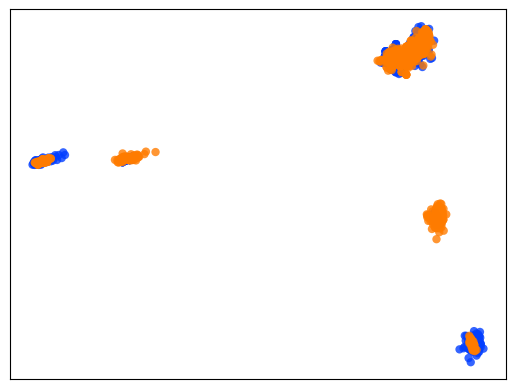

Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Layer: 25 Pos: None
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])


/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:825: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "means": torch.tensor(means),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:826: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "stds": torch.tensor(stds),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expl_vars = torch.tensor(ret["proportion_expl_var"]).float().cpu()
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:177: U

x-dim: 0
y-dim: 1
Top Expl Vars: tensor([0.1714, 0.1110, 0.0851, 0.0705, 0.0456])
Vis Expl Vars: tensor(0.1714) tensor(0.1110)


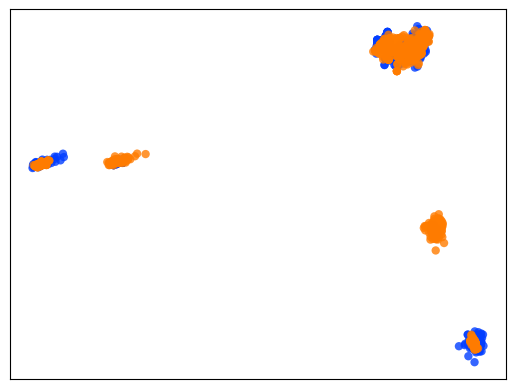

Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Layer: 26 Pos: None
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])


/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:825: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "means": torch.tensor(means),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:826: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "stds": torch.tensor(stds),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expl_vars = torch.tensor(ret["proportion_expl_var"]).float().cpu()
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:177: U

x-dim: 0
y-dim: 1
Top Expl Vars: tensor([0.1740, 0.1186, 0.0866, 0.0713, 0.0450])
Vis Expl Vars: tensor(0.1740) tensor(0.1186)


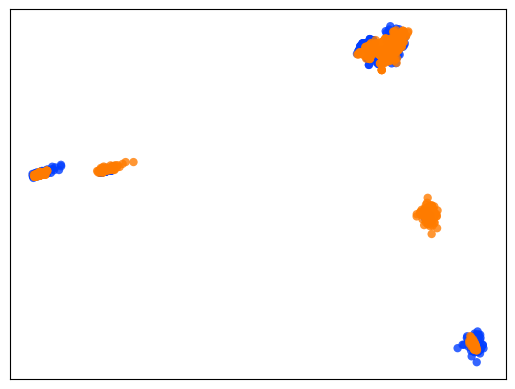

Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Layer: 27 Pos: None
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])


/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:825: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "means": torch.tensor(means),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:826: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "stds": torch.tensor(stds),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expl_vars = torch.tensor(ret["proportion_expl_var"]).float().cpu()
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:177: U

x-dim: 0
y-dim: 1
Top Expl Vars: tensor([0.1774, 0.1221, 0.0882, 0.0716, 0.0456])
Vis Expl Vars: tensor(0.1774) tensor(0.1221)


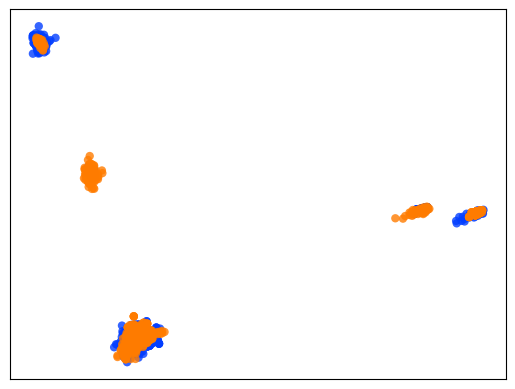

Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Layer: 28 Pos: None
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])


/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:825: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "means": torch.tensor(means),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:826: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "stds": torch.tensor(stds),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expl_vars = torch.tensor(ret["proportion_expl_var"]).float().cpu()
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:177: U

x-dim: 0
y-dim: 1
Top Expl Vars: tensor([0.1801, 0.1299, 0.0927, 0.0773, 0.0453])
Vis Expl Vars: tensor(0.1801) tensor(0.1299)


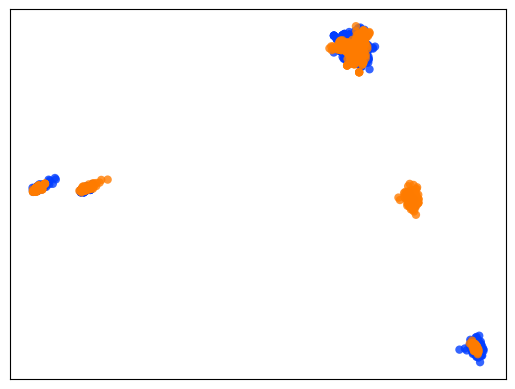

Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Layer: 29 Pos: None
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])


/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:825: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "means": torch.tensor(means),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:826: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "stds": torch.tensor(stds),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expl_vars = torch.tensor(ret["proportion_expl_var"]).float().cpu()
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:177: U

x-dim: 0
y-dim: 1
Top Expl Vars: tensor([0.1819, 0.1338, 0.0971, 0.0812, 0.0443])
Vis Expl Vars: tensor(0.1819) tensor(0.1338)


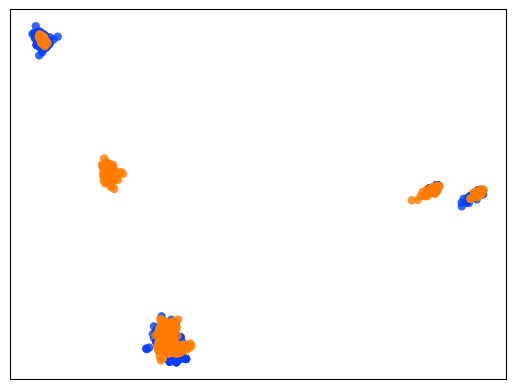

Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Layer: 30 Pos: None
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])


/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:825: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "means": torch.tensor(means),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:826: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "stds": torch.tensor(stds),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expl_vars = torch.tensor(ret["proportion_expl_var"]).float().cpu()
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:177: U

x-dim: 0
y-dim: 1
Top Expl Vars: tensor([0.1805, 0.1412, 0.1101, 0.0876, 0.0455])
Vis Expl Vars: tensor(0.1805) tensor(0.1412)


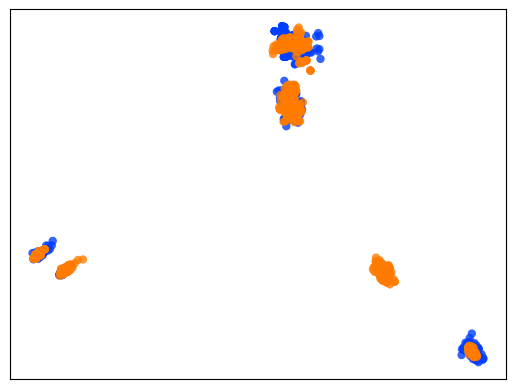

Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Layer: 31 Pos: None
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])


/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:825: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "means": torch.tensor(means),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:826: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "stds": torch.tensor(stds),
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expl_vars = torch.tensor(ret["proportion_expl_var"]).float().cpu()
/data/grantsrb/src/rep_divergence/divergence/divergence_utils.py:177: U

x-dim: 0
y-dim: 1
Top Expl Vars: tensor([0.1847, 0.1675, 0.1216, 0.0985, 0.0459])
Vis Expl Vars: tensor(0.1847) tensor(0.1675)


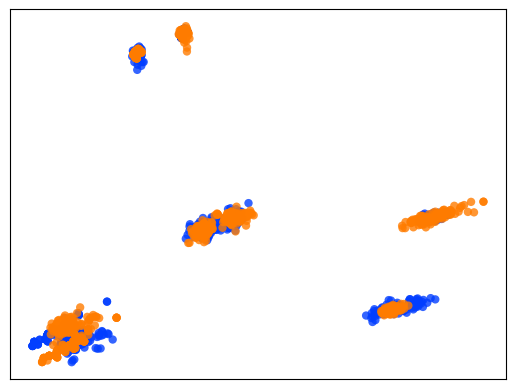

Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost
Computing EMD
Computing Cosine Cost


base_emd    4.146098
emd         8.209701
dtype: float64

In [7]:
from divergence_utils import visualize_states, collect_divergences
np.random.seed(12345)
torch.manual_seed(12345)

n_samples = 5
sample_size = 5000
layer = None
pos = None

emd_df_dict = {
    "sample_id": [],
    "pos": [],
    "layer": [],
    "mse": [],
    "emd": [],
    "base_emd": [],
}


print()
for layer in range(natty_hstates.shape[1]):
    natty_states, intrv_states = filter_by_layer_and_position(
        natty_hstates, intrv_hstates, layer=layer, pos=pos
    )
    print("Layer:", layer, "Pos:", pos)
    print("Natty:", natty_states.shape)
    print("Intrv:", intrv_states.shape)
    for samp_id in range(n_samples):
        p = str(pos)
        if samp_id==0:
            visualize_states(
                natty_states,
                intrv_states,
                xdim=0,
                ydim=1,
                save_name=f"figs/mean_diff_layer{layer}_pos{p}.png",
                expl_var_threshold=0,
                visualize=samp_id==0,
                #verbose=samp_id==0,
            )
        diffs = collect_divergences(
            natty_vecs=natty_states,
            intrv_vecs=intrv_states,
            sample_size=sample_size,
        )
        mse = diffs["mse"]
        emd = diffs["emd"]
        base_emd = diffs["base_emd"]
        emd_df_dict["sample_id"].append(samp_id)
        emd_df_dict["pos"].append(pos)
        emd_df_dict["layer"].append(layer)
        for k,v in diffs.items():
            if k not in emd_df_dict:
                emd_df_dict[k] = []
            emd_df_dict[k].append(float(v))
    
emd_df = pd.DataFrame(emd_df_dict)
emd_df[["base_emd","emd",]].mean()
    

In [8]:
emd_df = pd.DataFrame(emd_df_dict)
emd_df.groupby(["layer"]).mean()

,sample_id,pos,mse,emd,base_emd,cost_cos,base_cost_cos
layer,,,,,,,
0,2.0,NaN,0.000223,4.591966,4.192843,0.086387,0.087524
1,2.0,NaN,0.000331,3.812425,2.939645,0.080909,0.085520
2,2.0,NaN,0.000709,4.715240,3.533781,0.093583,0.075331
3,2.0,NaN,0.001173,7.106244,4.385388,0.100430,0.079722
4,2.0,NaN,0.001849,7.559691,4.874285,0.093270,0.079133
5,2.0,NaN,0.002578,8.242039,4.710367,0.085937,0.065178
6,2.0,NaN,0.003268,8.653488,4.446402,0.085886,0.061320
7,2.0,NaN,0.004388,9.492608,4.551070,0.078815,0.052362
8,2.0,NaN,0.004865,10.026150,4.874963,0.080093,0.057541


In [9]:
all_cols = []
for col in ["emd", "cost_cos"]:
    if col not in emd_df.columns: continue
    base = "base_"+col
    diff = "diff_"+col
    perc = "perc_"+col
    frac = "frac_"+col
    emd_df[diff] = emd_df[col]-emd_df[base]
    emd_df[perc] = emd_df[diff]/emd_df[base]
    emd_df[frac] = emd_df[col]/emd_df[base]
    all_cols.append(col)
    all_cols.append(base)
    all_cols.append(diff)
    all_cols.append(perc)
    all_cols.append(frac)
emd_df.groupby(["layer"])[all_cols].mean()

,emd,base_emd,diff_emd,perc_emd,frac_emd,cost_cos,base_cost_cos,diff_cost_cos,perc_cost_cos,frac_cost_cos
layer,,,,,,,,,,
0,4.591966,4.192843,0.399123,0.105223,1.105223,0.086387,0.087524,-0.001137,-0.013085,0.986915
1,3.812425,2.939645,0.872780,0.299887,1.299887,0.080909,0.085520,-0.004612,-0.043498,0.956502
2,4.715240,3.533781,1.181459,0.349472,1.349472,0.093583,0.075331,0.018251,0.254098,1.254098
3,7.106244,4.385388,2.720856,0.641495,1.641495,0.100430,0.079722,0.020708,0.267322,1.267322
4,7.559691,4.874285,2.685406,0.557537,1.557537,0.093270,0.079133,0.014137,0.186006,1.186006
5,8.242039,4.710367,3.531673,0.758232,1.758232,0.085937,0.065178,0.020758,0.321284,1.321284
6,8.653488,4.446402,4.207085,0.968925,1.968925,0.085886,0.061320,0.024566,0.422199,1.422199
7,9.492608,4.551070,4.941538,1.089558,2.089558,0.078815,0.052362,0.026453,0.510605,1.510605
8,10.026150,4.874963,5.151187,1.067706,2.067706,0.080093,0.057541,0.022552,0.395073,1.395073


In [10]:
emd_df["method"] = "mean_diff"
if not os.path.exists("csvs/"):
    os.mkdir("csvs/")
emd_df.to_csv("csvs/mean_diff_emd.csv", header=True, index=False)